In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from astropy.stats import bootstrap as bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
import os
import string
import seaborn as sns
from matplotlib import patheffects as pe
import json

In [2]:
# fpath_dps = '/gpfs/gpfs0/project/quinnlab/smj5vup/omoScenarios/omoScenarios/BestPolicyEachObjCC/Timeseries/DPS_MEF/'
fpath_dps = '../../Timeseries/DPS_MEF/'
fpath_uc = '../../Timeseries/Uncontrolled/'
# fpath_d = '/gpfs/gpfs0/project/quinnlab/smj5vup/omoScenarios/omoScenarios/BestPolicyEachObjCC/Extremes/DPS_MEF/'
fpath_d = '../../Extremes/DPS_MEF/'
fpath_u = '../../Extremes/Uncontrolled'
HUC_7Q = pd.read_csv('../../../Historical/Extremes/UC_7Q.csv', index_col = 'Unnamed: 0')
HUC_AMS = pd.read_csv('../../../Historical/Extremes/Uncontrolled_AMS.csv', index_col = 'date')

PROJECTIONS = np.unique([f.split("_")[0] for f in os.listdir(fpath_dps)])

In [3]:
# I think we're missing some projections. Only 42, should be 48 I believe. Need to re-run. 
len(PROJECTIONS)

48

In [4]:
class Scenario:
    def __init__(self, projections, fpath_extremes, scenario_string, index_col, historical_uncontrolled_timeseries, color, label, time_period = "Mid"):
        self.projections = projections
        self.all_flows = dict.fromkeys(self.projections)
        self.uncontrolled_timeseries = historical_uncontrolled_timeseries
        self.cmap_val = color # for plotting
        self.label = label # for plotting
        self.time_period = time_period
        for proj in self.projections:
            self.all_flows[proj] = pd.read_csv(os.path.join(fpath_extremes, f'{proj}_{scenario_string}.csv'), parse_dates=True, index_col = index_col)
    
    def ks_test_p_values(self, policies, colname="00", mc = 2040, lc = 2070):
        self.policies = policies
        self.pvals = dict.fromkeys(self.policies)
        self.projection_ls = dict.fromkeys(self.policies)
        for policy in policies:
            self.projection_ls[policy] = []
        
        if self.time_period == "Mid":
            start = mc
            end = lc
        else:
            start = lc 
            end = 2100
        
        for policy in self.policies:
            self.pvals[policy] = []
            
            for proj in self.projections:
                self.flows = self.all_flows[proj][(self.all_flows[proj].index.year >= start) & (self.all_flows[proj].index.year <= end-1)]
                # KS test
                _, p = ss.ks_2samp(self.flows[policy], self.uncontrolled_timeseries[colname])
                # Add to dictionary
                self.pvals[policy].append(p)
                
                if p > 0.05:
                    self.projection_ls[policy].append(proj)
                
    def _percent_dict(self, pvals):
        """ 
        robustness metric is the percent of projections where distribution of flows 
        is not statistically significantly different than the historical uncontrolled scenario. 
        """
        nc_dict = dict.fromkeys(self.policies)
        robustness_metric = dict.fromkeys(self.policies)

        for policy in self.policies:
            not_ss = len([f for f in pvals[policy] if f > 0.05]) / len(pvals[policy])
            nc_dict[policy] = not_ss
            robustness_metric[policy] = not_ss
        
        # sort policies 
        robustness_metric = dict(sorted(robustness_metric.items(), key=lambda item: item[1], reverse=True))
        robust_policy = max(robustness_metric, key=robustness_metric.get)
        
        return robustness_metric, robust_policy
    
    def calculate_robustness_metric(self):
        self.robustness_metric, self.robust_policy = self._percent_dict(self.pvals)
        self.ordered_policies = [f for f in self.robustness_metric.keys()]
        self.robustness_metric_df = pd.DataFrame.from_dict(self.robustness_metric, orient='index', columns=['Robustness Metric'])
    
    def override_robust_policy(self, policy):
        self.robust_policy = policy


In [5]:
class Compromise:
    def __init__(self, policies, color, label):
        self.policies = policies
        self.cmap_val = color # for plotting
        self.label = label # for plotting
        self.robustness_metric = dict.fromkeys(policies)
    
    def calculate_robustness_metric(self, sevenQ, ams):
        for policy in self.policies:
            rm = len([f for f, i  in zip(ams.pvals[policy], sevenQ.pvals[policy]) if (f > 0.05) & (i > 0.05)]) / len(sevenQ.pvals[policy])
            self.robustness_metric[policy] = rm
            
        self.robustness_metric = dict(sorted(self.robustness_metric.items(), key=lambda item: item[1], reverse=True))
        self.ordered_policies = [f for f in self.robustness_metric.keys()]
        self.robust_policy = max(self.robustness_metric, key=self.robustness_metric.get)
        # make a dataframe
        self.robustness_metric_df = pd.DataFrame.from_dict(self.robustness_metric, orient='index', columns =['Robustness Metric'])

In [6]:
class ControlPolicy:
    projections = PROJECTIONS
    
    def __init__(self, fpath_extremes):
        self.sevenQ = Scenario(self.projections, fpath_extremes, "7Q", 'Unnamed: 0', HUC_7Q, 0.25, "Low Flows")
        self.ams =  Scenario(self.projections, fpath_extremes, "AMS", 'date', HUC_AMS, 0.75, "High Flows")
        self.policies = [f for f in self.sevenQ.all_flows['ACCESS1-0.rcp45'].columns if f != 'Year']
        self.compromise = Compromise(self.policies, 0.5, "Compromise")
    
    def ks_test(self):
        self.sevenQ.ks_test_p_values(self.policies)
        self.sevenQ.calculate_robustness_metric()
        self.ams.ks_test_p_values(self.policies)
        self.ams.calculate_robustness_metric()
    
    def compromise_policy(self):
        self.compromise.calculate_robustness_metric(self.sevenQ, self.ams)

In [7]:
# DPS
dps = ControlPolicy(fpath_d)
dps.ks_test()

In [8]:
dps.compromise_policy()

In [9]:
dps.compromise.robustness_metric_df[dps.compromise.robustness_metric_df.index == 'P14']

,Robustness Metric
P14,0.166667


In [10]:
dps.sevenQ.robustness_metric_df

,Robustness Metric
P86,0.729167
P14,0.708333
P41,0.604167
P04,0.541667
P38,0.520833
...,...
P78,0.000000
P79,0.000000
P88,0.000000
P91,0.000000


In [14]:
# Uncontrolled
uc = ControlPolicy(fpath_u)
uc.ks_test()

In [15]:
uc.policies

['PUC']

In [16]:
uc.sevenQ.robustness_metric_df

,Robustness Metric
PUC,0.645833


In [17]:
uc.compromise_policy()

In [18]:
uc.compromise.robustness_metric_df

,Robustness Metric
PUC,0.166667


In [19]:
uc.sevenQ.robustness_metric_df

,Robustness Metric
PUC,0.645833


In [20]:
# Plot 

In [21]:
class Plotter:
    def __init__(self, dps, uncontrolled):
        self.dps = dps # DPS
        self.puc = uncontrolled # projected uncontrolled
        self.cmap = plt.cm.get_cmap("RdBu")
    
    def _plot_robustness_metric(self, ax, dps_series, puc_series, title, label=False):
        ax.plot(sorted(dps_series['Robustness Metric']*100, reverse=True), color='#ff7f00', linestyle='solid', label="" if label == False else "Optimized")
        ax.axhline(puc_series['Robustness Metric'].iloc[0]* 100, color="black", linestyle="dashed", label="" if label == False else "Uncontrolled")
        ax.set_xlabel("Policies", fontsize=14)
        ax.set_ylim(-1.5,65)
        ax.set_xticks(np.arange(0, 125, 25))
        ax.set_xticklabels("")
        ax.set_title(title)
    
    def _line_formatting(self, ax, scenario_a, scenario_b, label, scale_value=0.65, add_value=0.02):
        ax.axvline(scenario_a.ordered_policies.index(scenario_b.robust_policy),
                   ymin=scenario_a.robustness_metric[scenario_b.robust_policy] + add_value, # /scale_value + add_value/scale_value,
                   ymax= 0 , color=self.cmap(scenario_b.cmap_val), 
                   linestyle = 'solid', linewidth = 2,marker='o', markevery=2, markersize=4, 
                   label = label,
                   path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])
    

    def _plot_lines(self, ax, scenario_class, alternate_scenario_1, alternate_scenario_2, label= False):
        if label == False:
            label = ["","",""]
        else:
            label = [scenario_class.label, alternate_scenario_1.label, alternate_scenario_2.label]
        self._line_formatting(ax, scenario_class, scenario_class, label[0])
        self._line_formatting(ax, scenario_class, alternate_scenario_1, label[1])
        self._line_formatting(ax, scenario_class, alternate_scenario_2, label[2])
        
    
    def plot(self):
        # initialize figure
        fig, (ax1, ax2, ax3) = plt.subplots(1,3)
        sns.set_theme()

        self._plot_robustness_metric(ax1, self.dps.sevenQ.robustness_metric_df, self.puc.sevenQ.robustness_metric_df, "Low Flows", True)
        self._plot_robustness_metric(ax2, self.dps.ams.robustness_metric_df, self.puc.ams.robustness_metric_df, "High Flows")
        self._plot_robustness_metric(ax3, self.dps.compromise.robustness_metric_df, self.puc.compromise.robustness_metric_df, "High and Low Flows")

        # 7QS plot 

        self._plot_lines(ax1, self.dps.sevenQ, self.dps.ams, self.dps.compromise)
        self._plot_lines(ax2, self.dps.ams, self.dps.sevenQ, self.dps.compromise, True)
        self._plot_lines(ax3, self.dps.compromise, self.dps.sevenQ, self.dps.ams)

        ax_ls = [ax1, ax2, ax3]
        for i in range(len(ax_ls)) :
            #ax_ls[i].set_xticks([0,0,0.5,0.75,100])

            ax_ls[i].text(0.01, 0.93, "("+ string.ascii_lowercase[i+1] + ")", transform=ax_ls[i].transAxes, size=13, weight='bold')
            ax_ls[i].tick_params(axis='y', labelsize=14)
            ax_ls[i].set_ylim(-2,100)
            ax_ls[i].set_yticks([0, 25, 50, 75, 100])
        # for ax in [ax2, ax3]:
        #     ax.set_yticklabels("")

        #ax1.legend()
        ax1.set_xlabel("Policies")
        ax1.set_ylabel("No Statistically Significant Difference\n From Historical Uncontrolled (%)")
        ax1.legend(bbox_to_anchor=(0.9, -0.2), ncol=2)

        ax2.legend(bbox_to_anchor=(2.75,-0.2), ncol=4)
        fig.set_size_inches([9.3625, 3.1625])
        fig.tight_layout()

        plt.savefig('Figures/Figure02.svg', bbox_inches='tight')
        plt.savefig('Figures/Figure02.png', bbox_inches='tight')
        plt.savefig('Figures/Figure02.pdf', bbox_inches='tight')


In [22]:
plotter = Plotter(dps, uc)

<ipython-input-21-53c0531cac5d>:68: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


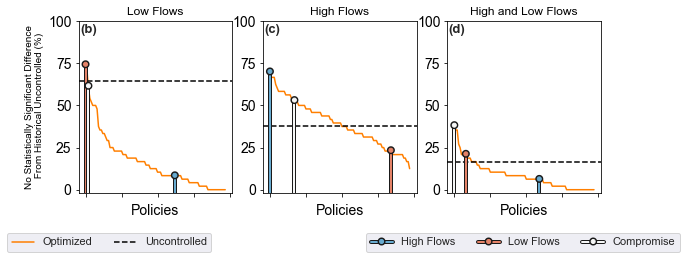

In [23]:
plotter.plot()

In [54]:
# result dictionary
import json
robust_policies = {
    "Low Flow": dps.sevenQ.robust_policy,
    "High Flow": dps.ams.robust_policy,
    "Compromise": dps.compromise.robust_policy,
    "PUC": uc.compromise.robust_policy
}

with open("results/robust-policies.json", "w") as outfile:
    json.dump(robust_policies, outfile)
#

In [55]:
robust_policies

{'Low Flow': 'P86', 'High Flow': 'P72', 'Compromise': 'P41', 'PUC': 'PUC'}

In [56]:

low_flow_dict = {
    dps.sevenQ.robust_policy: dps.sevenQ.projection_ls[dps.sevenQ.robust_policy],
    dps.ams.robust_policy: dps.sevenQ.projection_ls[dps.ams.robust_policy],
    dps.compromise.robust_policy: dps.sevenQ.projection_ls[dps.compromise.robust_policy],
    uc.sevenQ.robust_policy: uc.sevenQ.projection_ls[uc.sevenQ.robust_policy]
}

with open("results/low_flow_projections.json", "w") as outfile:
    json.dump(low_flow_dict, outfile)

In [57]:

high_flow_dict = {
    dps.sevenQ.robust_policy: dps.ams.projection_ls[dps.sevenQ.robust_policy],
    dps.ams.robust_policy: dps.ams.projection_ls[dps.ams.robust_policy],
    dps.compromise.robust_policy: dps.ams.projection_ls[dps.compromise.robust_policy],
    uc.ams.robust_policy: uc.ams.projection_ls[uc.ams.robust_policy]
}

with open("results/high_flow_projections.json", "w") as outfile:
    json.dump(high_flow_dict, outfile)

## Get all policies

In [29]:
sqt = uc.sevenQ.robustness_metric_df['Robustness Metric'][0]

In [40]:
sq_policies = dps.sevenQ.robustness_metric_df[dps.sevenQ.robustness_metric_df['Robustness Metric'] >= sqt].index.to_list()

In [41]:
sq_policies

['P86', 'P14']

In [32]:
amst = uc.ams.robustness_metric_df['Robustness Metric'][0]

In [42]:
ams_policies = dps.ams.robustness_metric_df[dps.ams.robustness_metric_df['Robustness Metric'] >= amst].index.to_list()

In [45]:
ct = uc.compromise.robustness_metric_df['Robustness Metric'][0]

In [46]:
c_policies = dps.compromise.robustness_metric_df[dps.compromise.robustness_metric_df['Robustness Metric'] >= ct].index.to_list()

In [48]:

robust_policies_dict = {
    "Low Flows": sq_policies,
    "High Flows": ams_policies,
    "Both Policies": c_policies,
}

with open("results/all_robust_policies.json", "w") as outfile:
    json.dump(robust_policies_dict, outfile)